# Inteligência Computacional

## Projeto DATA MINING CUP Competition 2013

In [426]:
import pandas as pd

from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt

In [427]:
data = pd.read_csv('transact_train.csv')

## Tratando Granularidade e Criando Variáveis

### Agrupando Dados
agrupando todos os dataframes separados por sessionNo em um vetor

In [428]:
def groupData(data, field):
    group = data[field]
    agg = data.groupby([group])
    splited = []
    for group in agg:
        splited.append(pd.DataFrame(data = group[1], columns=data.columns.values))
    return splited


In [429]:
splited = groupData(data,"sessionNo")
# vetor de dataframes separados por sessionNo
#splited[2]

### Criando Variáveis da mudança de granularidade
Essas são as variáveis que criamos buscando recuperar dados perdidos na mudança da granularidade
##### bStep_count
    Quantidade de bStep maiores que 3 de cada sessão
##### countLog
    Numero de log de cada sessão
##### modes
    Moda do bStep de cada Sessão.

In [430]:
def granul_fields(splited):
    bStep_count = []
    countLog = []
    modes = []
    for session in splited:
        countStep = 0
        countLog.append(len(session))
        modes.append(session['bStep'].mode()[0])
        for j in range(len(session)):
            if(session['bStep'].iloc[j] != "?" and int(session['bStep'].iloc[j]) >= 3):
                countStep +=1
        bStep_count.append(countStep)
    return bStep_count,countLog,modes

In [431]:
bStep_count,countLog,modes = granul_fields(splited)
#bStep_count
#countLog
#modes

### Mudando Granularidade

In [432]:
#Mudando a granularidade
def granul_change(data):
    return data.groupby(['sessionNo'], as_index=False).last()

data = granul_change(data)

### Criando Variáveis de Correlação

As técnicas de inteligência artificial pressupõem que as variáveis não têm correlação entre si, apenas relação direta com a variável alvo.

Essas são as variáveis que criamos buscando informar uma correlação entre variáveis
##### diffCounts
    diferença entre cCount e bCount
##### durCount
    Razão entre a duração e o Ccount

In [433]:
def correlation_fields(data):
    # diffCounts
    diffCounts = (data['cCount']-data['bCount']).values

    # durCount
    durCount = (data['duration']/data['cCount'])
    durCount = durCount.replace(float("inf"), "?", regex=False).values
    # Testar depois com outros valores para tratar o inf
    return diffCounts,durCount

In [434]:
diffCounts,durCount = correlation_fields(data)
#diffCounts
#durCount

### Atribuindo numeros às classes
Buscando melhorar o processamento, transformamos todos os nomes de classe para numeros, numa sequencia de 0 ao numero de classes -1 para cada classe diferente.

In [435]:
##Ver os valores diferentes de availability
#data.groupby(['availability'], as_index=False).last()

##Ver os valores diferentes de onlineStatus
#data.groupby(['onlineStatus'], as_index=False).last()

##Ver os valores diferentes de order
#data.groupby(['order'], as_index=False).last()

In [436]:
def nominal_to_number(data):
    # availability
    data.loc[(data.availability == 'completely not determinable'),'availability']= 0
    data.loc[(data.availability == 'completely not orderable'),'availability']= 1
    data.loc[(data.availability == 'completely orderable'),'availability']= 2
    data.loc[(data.availability == 'mainly not determinable'),'availability']= 3
    data.loc[(data.availability == 'mainly not orderable'),'availability']= 4
    data.loc[(data.availability == 'mainly orderable'),'availability']= 5
    data.loc[(data.availability == 'mixed'),'availability']= 6
    
    # onlineStatus
    data.loc[(data.onlineStatus == 'y'),'onlineStatus']= 1
    data.loc[(data.onlineStatus == 'n'),'onlineStatus']= 0
    
    return data

In [437]:
data = nominal_to_number(data)

# order (está fora porque a etapa que reutiliza esta função não converte a order)
data.loc[(data.order == 'y'),'order']= 1
data.loc[(data.order == 'n'),'order']= 0

### Inserindo as colunas das variáveis criadas
Com as variáveis criadas, adicionamos ao conjunto de dados com a granularidade já alterada.

In [438]:
def insert_column (data,fields,fields_name):
    index = len(data.columns)-1
    for i in range(len(fields)):
        data.insert(index + i,fields_name[i],fields[i],True)
    return data

In [439]:
def remove_column(data, fields_name):
    for i in fields_name:
        data.drop(i, inplace=True, axis=1)
    return data

In [440]:
fields = [bStep_count,countLog,modes,diffCounts,durCount]
fields_name = ['bStep_count','countLog','modes','diffCounts','durCount']
data = insert_column(data,fields,fields_name)

data = remove_column(data,['customerNo'])
data = data.fillna(value=0)

In [441]:
#data

### Tratando Missing Values

In [442]:
backupData = deepcopy(data) #data é minimo com moda
data2 = deepcopy(data) # minimo com New
data3 = deepcopy(data) # maximo com moda
data4 = deepcopy(data) # maximo com New
data5 = deepcopy(data) # media com moda
data6 = deepcopy(data) # media com New
data7 = deepcopy(data) # exclusão com moda
data8 = deepcopy(data) # exclusão com New

In [443]:
#definindo funções para variáveis numéricas:
def replaceMissingbyMin(data, field):
    if(field == 'durCount'):
        mini = data['durCount'].mask(data['durCount'] == '?').min()
    else:
        mini = data[field].min()
    data[field] = data[field].replace('?', mini, regex=False)
    
def replaceMissingbyMax(data, field):
    maxi = data[data[field]!="?"][field].max()
    data[field] = data[field].replace('?', maxi, regex=False)

def replaceMissingbyMedian(data, field):
    median = data[data[field]!="?"][field].median()
    data[field] = data[field].replace('?', median, regex=False)
    
def removeMissing(data, field):
    data[field] = data[field].replace('?', float("NaN"))
    data.dropna(axis='index', inplace = True)
    #for i in range(len(data)):
    #    row = data.iloc[i]
    #    print(i)
    #    if(row[field] == '?'):
    #        data.drop([i], axis=0)
     #retorna o dataframe onde não tem nenhuma '?'
    

In [444]:
#Tratando os missing values numéricos nos dataframes:
varsNum = ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep', 'maxVal', 
           'customerScore', 'accountLifetime', 'payments', 'age', 'lastOrder',"bStep_count", "modes" , "countLog" , "diffCounts", "durCount"]

for var in varsNum:
    replaceMissingbyMin(data, var)
    replaceMissingbyMin(data2, var)
    replaceMissingbyMax(data3, var)
    replaceMissingbyMax(data4, var)
    replaceMissingbyMedian(data5, var)
    replaceMissingbyMedian(data6, var)
    removeMissing(data7, var)
    removeMissing(data8, var)

/home/victor/.local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [445]:
#definindo funções para variáveis categóricas:
def replaceMissingbyMode(data, field):
    mode = data[field].mode()
    if((mode == '?').bool()):
        mode = data[field].value_counts().index[1]
    data[field] = data[field].replace('?', mode[0], regex=False)
    
def replaceMissingbyNew(data, field):
    data[field] = data[field].replace('?', -1, regex=False)

In [446]:
categories = ['onlineStatus', 'availability', 'address']
for category in categories:
    replaceMissingbyMode(data, category)
    replaceMissingbyMode(data3, category)
    replaceMissingbyMode(data5, category)
    replaceMissingbyMode(data7, category)
    replaceMissingbyNew(data2, category)
    replaceMissingbyNew(data4, category)
    replaceMissingbyNew(data6, category)
    replaceMissingbyNew(data8, category)

In [447]:
#Salva a tabela
datas = [data, data2, data3, data4, data5, data6, data7, data8]
data = deepcopy(backupData)

In [448]:
#Finish
datas[7].to_csv("datas_0.csv")

### Avaliando conjunto de Dados

Nesta sessão, será escolhido dentre as bases de dados, a que se comporta melhor para classificação. A métrica utilizada é a área da curva roc. A base de dados que obtiver a melhor área ROC será a utilizada na próxima etapa.

In [449]:
model = [0]*8 ## serão guardados os models
roc_s = [0]*8 ## serao guardados os scores de curva roc
roc_c = [0]*8 ## serao guardados as curvas roc

In [450]:
def applyRandomForrest(data):
    # Separar os dados em entrada (X) e saida (Y)
    Y = data.iloc[:,-1]
    X = data.iloc[:,0:-1] # [:,0:-1]
    
    # Dividir os dados em treinamento e teste
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state=42)
    
    # Criar e Treinar modelo
    forest = RandomForestClassifier(n_estimators=10,max_features=5,criterion="entropy")
    model = forest.fit(X_train, Y_train)
    
    #Avaliando o modelo
    Y_predict = model.predict(X_test)
    score = roc_auc_score(Y_test,Y_predict)
    roc = roc_curve(Y_test,Y_predict)
    
    return model, score,roc

In [451]:
for i in range(8):
    model[i], roc_s[i], roc_c[i] = applyRandomForrest(datas[i])


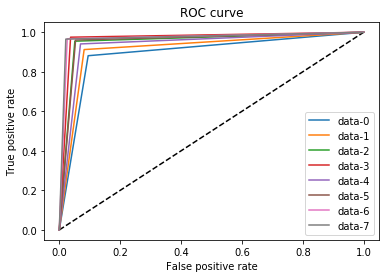

In [452]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(8):
    fpr_rf, tpr_rf,_ = roc_c[i]
    plt.plot(fpr_rf, tpr_rf, label='data-'+str(i))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [453]:
#selecionando a melhor base
data_index = roc_s.index(max(roc_s))

In [454]:
pd.DataFrame({"Roc Score":roc_s})

,Roc Score
0,0.893227
1,0.915350
2,0.951857
3,0.968937
4,0.935609
5,0.953630
6,0.970523
7,0.971935


In [455]:
data_index

7

### Submetendo modelo Escolhido
Isso nos faz perceber apenas que ele foi o melhor dentre os que fizemos. Isso significa que o melhor tratamento de missing value dentro do nosso tratamento total é justamente os tratamentos:
##### Numerico 
remover linha
##### Nominal
Criar classe

Contudo, a remoção da linha não cabe para a validação, já que é preciso gerar uma resposta para cada linha
Por isso, o tratamento de missing values numericos não será o de remoção e sim o catalogado como segundo melhor, que foi o de máximo na base de dados 3, e esse conjunto de dados será aplicado ao modelo de maior taxa de acerto, que foi onde os valores foram removidos

##### Numerico 
substituir pelo maximo
##### Nominal
Criar classe


Sendo assim, para avaliar o modelo, faremos os mesmos processos para o conjunto de validação da competição
criando as 5 variáveis, mudando a glanularidade e tratando os missing-values da mesma forma.
O resultado será a nossa pontuação na competição

In [456]:
validation_data = pd.read_csv("transact_class.csv")

In [457]:
# Tratamento de igual modo

# Dividindo sessoes
validation_splited = groupData(validation_data,"sessionNo")

# Criando as 5 variaveis
validation_fields = [0]*5

# Variaveis de granularidade #bStep_count #countLog #modes
validation_fields[0],validation_fields[1],validation_fields[2] = granul_fields(validation_splited)

# Mudando a granularidade
validation_data = granul_change(validation_data)

# Variaveis de correlação #diffCounts #durCount
validation_fields[3],validation_fields[4] = correlation_fields(validation_data)

# Mudando de nominal para numero (sem a Order)
validation_data = nominal_to_number(validation_data)

# Inserindo variáveis no conjunto de dados
validation_data = insert_column(validation_data,validation_fields,fields_name)

# Removendo variaveis não utilizadas
validation_data = remove_column(validation_data,['customerNo'])

# Tratando MissingValues
for var in varsNum: #Numéricas
    replaceMissingbyMax(validation_data, var)
    #removeMissing(validation_data, var)
    
for category in categories: #Categóricas
    replaceMissingbyNew(validation_data, category)
    
#desencargo de consciência
validation_data = validation_data.fillna(value=0)

/home/victor/.local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [458]:
order = model[data_index].predict(validation_data)

In [459]:
submit = pd.DataFrame({'sessionNo' : validation_data.iloc[:,0], 'order': order})

### Avaliando submissão
Importando agora o gabarito da base de dados de validação, poderemos avaliar a taxa de acerto do nosso modelo

In [460]:
answer = pd.read_csv("realclass_t1.csv")

In [461]:
submit.insert(2,"prediction",answer["prediction"],True)

In [462]:
submit

,sessionNo,order,prediction
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,0
4,5,0,0
...,...,...,...
5106,5107,0,0
5107,5108,0,0
5108,5109,1,1
5109,5110,1,0


In [463]:
submit.insert(2,"hit",(submit['prediction']==submit['order']),True)

In [464]:
no_creativity = submit.groupby("hit").count()

In [465]:
no_creativity

,sessionNo,order,prediction
hit,,,
False,614,614,614
True,4497,4497,4497


In [466]:
hit_rate = no_creativity.iloc[1,0]/(no_creativity.iloc[0,0]+no_creativity.iloc[1,0])

In [467]:
hit_rate

0.8798669536294267

## Conclusão

### Ao se realizar os tratamentos dos missing values, verificou-se que o melhor desempenho da Curva ROC foi obtido ao se realizar a remoção dos missing values ( datas[6] e datas[7]), entretanto, tal tratamento não poderia ser realizado com a base de validação, visto que para submeter na competição é necessario enviar a predição de todas as sessões, assim, poderia realizar um outro tratamendo para os missing values na validação, ou escolher o terceiro tratamento com a melhor curva ROC, mas, como o objetivo do trabalho era utilizar o mesmo tratamento, este foi aplicado no código exibido acima.

### A melhora da curva ROC com a remoção do missing values pode ser atribuida a não existencia de variaveis "falsas", ou seja, que podem não condizer com o dado real do individuo e desta forma atrapalhar a classsificação.

### A taxa de acerto obtida foi satisfatoria, visto ser a primeira experiencia em tal área dos componentes do grupo, esta entretanto, devido as particularidades do Random Forest (as variáveis utilizadas em cada nó da árvore são selecionadas de forma aleatória) , varia um pouco a cada execução.